# FORESEE Models: ALP with Photon Couplings

## Load Libraries 

In [1]:
import sys, os
src_path = "../../"
sys.path.append(src_path)

import numpy as np
from src.foresee import Foresee, Utility, Model
from matplotlib import pyplot as plt

## 1. Specifying the Model

The phenomenology of the ALP with $\gamma$-couplings can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} \color{red}{m_{a}}^2 a^2  - \frac{\color{red}{g}}{4}a F^a_{\mu\nu} \tilde F^a_{\mu\nu}
\end{equation}

with the ALP mass $m_a$ and the coupling parameter $g$ as free parameters.

In [2]:
energy = "13.6"
modelname = "ALP-photon"
model = Model(modelname)

**Production** The ALP is mainly produced via the Primakoff Process. This process describes the conversion of a photon into an ALP in the presence of a strong electromagnetic field, for example close to a nucleus inside a medium. Following [1806.02348](https://arxiv.org/pdf/1806.02348.pdf) Eq (6), the conversion probability is given by 

\begin{equation}
 P(\gamma \to a) = \frac{1}{\sigma_{SM}} \int
  g^2 \frac{\alpha Z^2}{4} \times F(t)^2 \times \frac{p_a^4 \theta^4}{t^2} d\log\theta
\end{equation}

where $\sigma_{SM}\sim 5$ barn, the ALP momentum $p_a \approx E_\gamma$, $t = m_a^4 / (2E_\gamma^2) + E_\gamma^2 \theta^2$ and the form factor is given by $F(t) = a^2t/(1+a^2t)$ for $t<7.39m_e^2$ and $F(t) = 1/(1+t/d)$ for $t>7.39m_e^2$. To a good approximation, $\vec{p}_a = \vec{p}_\gamma$, so we can treat this as an $\gamma \to a$ conversion. For practical purposes, we will assume the concersion takes place in iron, which is the material of the TAN. 

Let us first define a conversion factor formula (where, in a slight abuse of notation, we define a mixing angle as $\sqrt{ P(\gamma \to a)}$). 

In [3]:
def conversion_factor(mass, coupling, p0):

    #define quantities
    alpha, me, ZFe, AFe = 1./137., 0.000511, 26, 56
    a, d  = 111.*ZFe**(-1./3.) / me,  0.164 * AFe**(-2./3.)
    SMXSinIGeV2 = 13311.9696379 

    # integration boundaries theta 
    logthmin, logthmax, nlogth = -12, 0, 20
    dlogth = (logthmax-logthmin)/float(nlogth)
        
    # conversion probability 
    xs_primakoff = 0
    k = p0.e
    for ltheta in np.linspace(logthmin+0.5*dlogth,logthmax-0.5*dlogth,nlogth):
        theta = 10**ltheta
        t = mass**4 / (2.*k**2) + k**2 * theta**2
        if t<7.39*me*me: ff = a*a*t/(1.+a*a*t)
        else: ff = 1./(1.+t/d)
        xs_primakoff += alpha * ZFe**2 / 4. * ff**2 * k**4 * np.sin(theta)**3 *theta / t**2 * dlogth * np.log(10)
    prob = xs_primakoff / SMXSinIGeV2
    if np.isnan(prob): prob=0
        
    # return
    return np.sqrt(prob)

We can now set up ALP production via the Primakoff process, where we model photon production using `EPOSLHC`, `SIBYLL`,  `QGSJET` and `PYTHIA-forward`. 

In [4]:
model.add_production_mixing(
    label='Primakoff',
    pid = "22",
    mixing = conversion_factor,
    generator=['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward'],
    energy = energy,
)

**Decay:** ALPs mainly decay to a pair of photons. 

In [5]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
)

decay_modes = ["gamma", "eegamma"] 
model.set_br_1d(
    modes = decay_modes,
    finalstates=[[22,22], [11,-11,22]],
    filenames=["model/br/"+mode+".txt" for mode in decay_modes],
)

We can now initiate FORESEE with the model that we just created. 

In [6]:
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

## 2. Event Generation

In the following, we want to study one specific benchmark point with $m_{A'}=50$ MeV and $g=2\cdot 10^{-4}$ GeV$^{-1}$ and export events as a HEPMC file. 

In [7]:
mass, coupling, = 0.05, 2e-4

First, we will produce the corresponding flux for this mass and a reference coupling $g_{ref}=1$. 

save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.05.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.05.npy


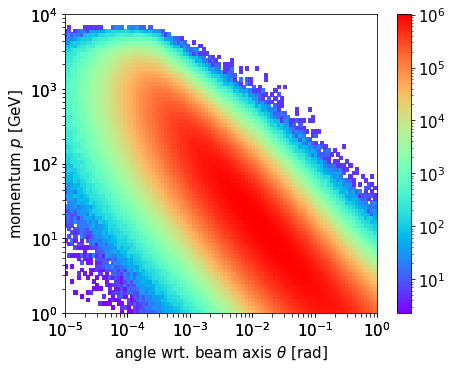

In [8]:
plot=foresee.get_llp_spectrum(mass=mass, coupling=1, do_plot=True)
plot.savefig("Spectrum_"+modelname+".pdf")
plot.show()

Next, let us define the configuration of the detector (in terms of position, size and luminosity). Here we choose FASER during 2022/2023. Note that we use the option `distance_prod` to indicate that the LLPs are not produced at the IP. 

In [9]:
foresee.set_detector(
    distance=474,
    distance_prod = 140,
    selection="np.sqrt(x.x**2 + (x.y+0.065)**2)< .1", 
    length=4.0, 
    luminosity=60, 
)

For our benchmark point, let us now look at how many particle decay inside the decay volume. We also export 1000 unweighted events as a HEPMC file. 

In [10]:
setupnames = ['EPOSLHC', 'SIBYLL', 'QGSJET', 'PYTHIA']
modes = {'Primakoff': ['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']}


momenta, weights, _ = foresee.write_events(
    mass = mass, 
    coupling = coupling, 
    energy = energy, 
    numberevent = 1000,
    filename = "model/events/test.hepmc", 
    return_data = True,
    weightnames=setupnames,
    modes=modes,
    nsample=100,
)

for isetup, setup in enumerate(setupnames):
    print("Expected number of events for "+setup+":", round(sum(weights[:,isetup]),3))

Expected number of events for EPOSLHC: 41.977
Expected number of events for SIBYLL: 40.412
Expected number of events for QGSJET: 35.632
Expected number of events for PYTHIA: 41.332


Let us plot the resulting energy distribution

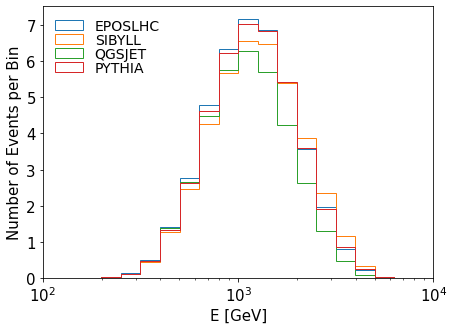

In [11]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
energies = [p.e for p in momenta], 
for isetup, setup in enumerate(setupnames):
    ax.hist(energies, weights=weights[:,isetup], bins=np.logspace(2,4, 20+1), histtype='step', label=setup) 
ax.set_xscale("log")
ax.set_xlim(1e2,1e4) 
ax.set_xlabel("E [GeV]") 
ax.set_ylabel("Number of Events per Bin") 
ax.legend(frameon=False, labelspacing=0, fontsize=14, loc='upper left')
plt.savefig("E_distribution_"+modelname+".pdf")
plt.show()

## 3. Sensitivity Reach

In the following, we will obtain the projected sensitivity for the LLP model. For this, we first define a grid of couplings and masses, and then produce the corresponding fluxes. 

In [12]:
masses=[round(x,5) for x in np.logspace(-2,0,41+1)]
couplings = np.logspace(-6,-2,81) 

for mass in masses: foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.01.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.01119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.01119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.01119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.01119.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.01252.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.01252.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.01252.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.01252.npy
save data to file: ./model/LLP_spectra/13.6TeV

save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.16577.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.18548.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.18548.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.18548.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.18548.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_Pythia8-Forward_m_0.20753.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_EPOSLHC_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_SIBYLL_m_0.2322.npy
save data to file: ./model/LLP_spectra/13.6TeV_Primakoff_QGSJET_m_0.2322.npy
save data to file: ./model/LLP_spectr

We can now plot the `production rate vs mass` using the `foresee.plot_production()` function.

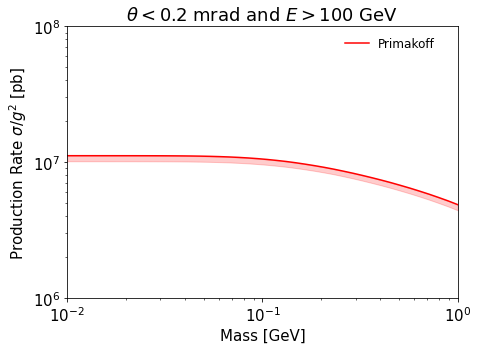

In [13]:
productions=[
    {"channels": ["Primakoff"], "color": "red", "label": r"Primakoff", "generators": ["EPOSLHC","QGSJET","SIBYLL",'Pythia8-Forward']  },
]

plot=foresee.plot_production(
    masses = masses,
    productions = productions,
    energy=energy,
    condition="logth<-3.7 and logp>2",  
    xlims=[0.01,1],ylims=[1e6,1e8],
    xlabel=r"Mass [GeV]",
    ylabel=r"Production Rate $\sigma/g^2$ [pb]",
    title=r"$\theta < 0.2$ mrad and $E > 100$ GeV",
    legendloc=(0.97,1),
    fs_label=12,
    ncol=2,
)
plot.savefig("Production_"+modelname+".pdf")

Let us now scan over various masses and couplings, and record the resulting number of evets. Note that here we again consider the FASER configuration, which we set up before.

In [14]:
#get reach  
list_nevents = {label:[] for label in setupnames}
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(mass=mass, energy=energy, couplings = couplings,modes=modes,nsample=10)
    for i,label in enumerate(setupnames): list_nevents[label].append(nevents.T[i])  
        
#save results
configuration='default'
for label in setupnames: 
    result = np.array([masses,couplings,list_nevents[label]], dtype='object')
    np.save("model/results/"+energy+"TeV_"+configuration+"_"+label+".npy",result)

We can now plot the results. For this, we first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [12]:
setups = [ 
    ["13.6TeV_default_EPOSLHC.npy", "EPOSLHC" , "red"        ,  "solid"  , 0., 3],
    ["13.6TeV_default_SIBYLL.npy" , "SYBILL"  , "magenta"    ,  "solid"  , 0., 3],
    ["13.6TeV_default_QGSJET.npy" , "QGSJET"  , "orange"     ,  "solid"  , 0., 3],
    ["13.6TeV_default_PYTHIA.npy" , "PYTHIA"  , "salmon"     ,  "solid"  , 0., 3],
]

Then we specify all the existing bounds, separating the bounds obtained by experimental collaboratios and theory recasts.  

In [49]:
bounds = [ 
    ["bounds_BESIII_2024.txt", "BESIII"  , 0.17,  6.7*10**-4, 0 ],
    ["bounds_BESIII_2022.txt", "BESIII"  , 0.17,  1.7*10**-4, 0 ],
    ["bounds_Belle2.txt"     , "Belle2"  , 0.210, 1.5*10**-3, 0 ],    
    ["bounds_PrimEx.txt"     , "PrimEx"  , 0.126, 1.2*10**-3, 90 ],
    ["bounds_LEP.txt"        , "LEP"     , 0.080, 6.0*10**-3, 0  ],
    ["bounds_SN1987.txt"     , "SN1987"  , 0.0105,6.0*10**-7, 0 ],
    ["bounds_E137.txt"       , "E137"    , 2e-2,  6.0*10**-6, 0 ],
    ["bounds_NuCal.txt"      , "NuCal"   , 0.080, 5.0*10**-6, -15 ],
    ["bounds_CHARM.txt"      , "CHARM"   , 0.041, 3.0*10**-5, -45 ],
    ["bounds_NA64.txt"       , "NA64"    , 0.035, 2.6*10**-4, 0 ],
    ["bounds_E141.txt"       , "E141"    , 0.017, 1.7*10**-3, 0 ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [50]:
projections = [
    ["limits_SHiP.txt",         "cyan"       ,"SHiP"                 , 0.152, 2.30e-5, -45  ],
    ["limits_SeaQuest.txt",     "teal"       ,"SeaQuest"             , 0.250, 8.00e-6, -48  ],
    ["limits_NA64.txt",         "turquoise"  ,"NA64"                 , 0.2500, 1.0e-4, 0  ],
    ["limits_NA62.txt",         "dodgerblue" ,"NA62"                 , 0.172, 1.0e-5, -45  ],
    ["limits_BelleII_inv.txt",  "blue"       ,r"Belle2 (1$\gamma$) 50ab$^{-1}$"  , 0.065, 1.50*10**-5, -45  ],
    ["limits_BelleII_3a.txt",   "blue"       ,r"Belle2 $3\gamma$"+ "\n" +r"50ab$^{-1}$"  , 0.235, 3.00*10**-5, 0  ],
    ["limits_PrimEX.txt",       "skyblue"    ,"PrimEx"               , 0.06, 0.7*10**-3, 0 ],
    ["limits_GlueX1pb.txt",     "deepskyblue","GlueX"                , 0.25, 2.5e-4, 0 ],
    ["limits_LUXE_NPOD1.txt",   "darkblue"   ,"LUXE NPOD"            , 0.08, 1.0*10**-4, -42],
]


We also want to show the branching fractions for some of the channels (name of file in model/br directory, color, line style, label, x-position, y-position)  

In [51]:
branchings = [
    ["gamma"    , "black", "solid", r"$\gamma\gamma$", 0.1, 0.3 ],
    ["eegamma"  , "blue" , "solid", r"$ee\gamma$"    , 0.1, 0.02],
]

Finally, we can plot everything using `foresee.plot_reach()`. Here we also add the dark matter relict target line obtained in [2105.07077](https://arxiv.org/abs/2105.07077).

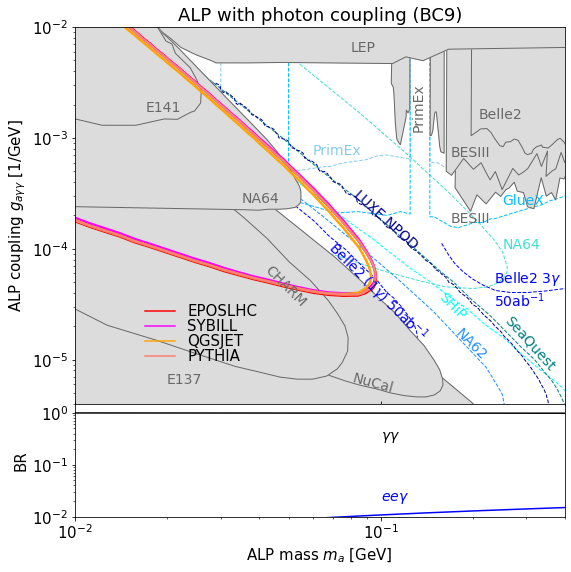

In [52]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="ALP with photon coupling (BC9)", 
    linewidths=2.5,
    xlims=[0.01,4e-1], 
    ylims=[4e-6,1e-2],    
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{a\gamma\gamma}$ [1/GeV]",
    legendloc=(0.4,0.30),
    branchings=branchings,
    figsize=(8,8),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("Reach_"+modelname+".pdf")
plot.show()